Version: 0.2.0
Previous condition number: 293.5272664754315
New condition number: 293.5272664754315


C:\Users\sudom\AppData\Local\Temp\ipykernel_8404\3693225332.py:149: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Iteration 10: Error = 50.52
Iteration 20: Error = 17.12
Iteration 30: Error = 5.62
Iteration 40: Error = 1.85
Iteration 50: Error = 0.62
Iteration 60: Error = 0.21
Iteration 70: Error = 0.07
Iteration 80: Error = 0.02
Iteration 90: Error = 0.01
Iteration 100: Error = 0.00


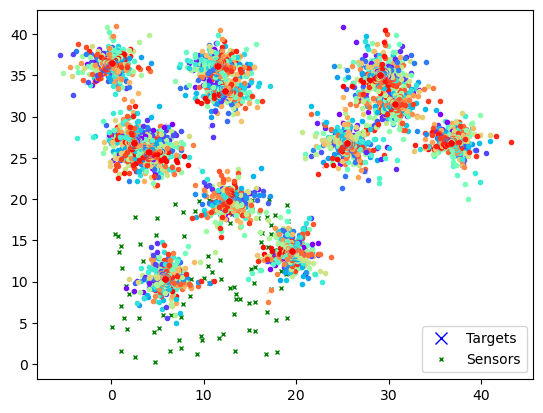

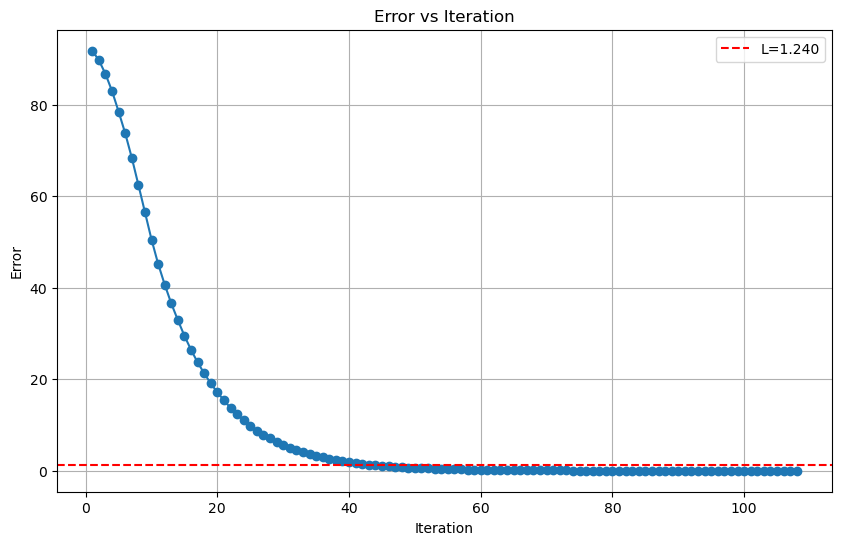

In [1]:
#!/usr/bin/env python
# coding: utf-8

import matplotlib.pyplot as plt
import time
import numpy as np
from random import random, randrange, sample
import plotly.graph_objects as go
import plotly
from typing import Dict, List, Set, Optional

__version__ = "0.2.0"
print(f"Version: {__version__}")

class Parameters:
    def __init__(self):
        self.d = 2  # number of dimensions (2D space)
        self.n = 0  # will be set when sensors are added
        self.m = 0  # will be set when targets are added
        self.N: Set[int] = set()  # indexes of sensors
        self.M: Set[int] = set()  # targets indexes
        self.s: Dict[int, np.ndarray] = {}  # sensors coordinates
        self.s_norms: Dict[int, float] = {}  # norms of sensors coordinates
        self.r: Dict[int, np.ndarray] = {}  # targets coordinates
        self.meas: Dict[int, Dict[int, float]] = {}  # measurements
        self.weight: np.ndarray = np.array([])  # weight matrix
        
        # Algorithm parameters (can be tuned)
        self.beta_1 = 0.01
        self.beta_2 = 0.01
        self.alpha = 0.1
        self.gamma = 0.1
        self.b = 1.0
        
    @property
    def beta(self):
        return self.beta_1 + self.beta_2
    
    def add_sensor(self, sensor_id: int, coordinates: np.ndarray):
        """Add a sensor with given ID and coordinates"""
        if sensor_id in self.N:
            raise ValueError(f"Sensor with ID {sensor_id} already exists")
        
        self.N.add(sensor_id)
        self.s[sensor_id] = coordinates
        self.s_norms[sensor_id] = np.sum(coordinates * coordinates)
        self.n = len(self.N)
        
    def add_target(self, target_id: int, coordinates: np.ndarray):
        """Add a target with given ID and coordinates"""
        if target_id in self.M:
            raise ValueError(f"Target with ID {target_id} already exists")
        
        self.M.add(target_id)
        self.r[target_id] = coordinates
        self.m = len(self.M)
        
    def generate_random_sensors(self, n: int, area_size: float = 20.0):
        """Generate n sensors with random coordinates in given area"""
        for i in range(1, n + 1):
            coords = np.array([random() * area_size, random() * area_size])
            self.add_sensor(i, coords)
    
    def generate_random_targets(self, m: int, area_size: float = 40.0):
        """Generate m targets with random coordinates in given area"""
        for i in range(1, m + 1):
            coords = np.array([random() * area_size, random() * area_size])
            self.add_target(i, coords)
    
    def calculate_measurements(self):
        """Calculate distances from all targets to all sensors"""
        self.meas = {}
        for target_id in self.M:
            self.meas[target_id] = {}
            for sensor_id in self.N:
                self.meas[target_id][sensor_id] = np.sum(
                    (self.r[target_id] - self.s[sensor_id]) ** 2)
    
    def generate_weight_matrix(self, connectivity: float = 0.5):
        """Generate random symmetric weight matrix with given connectivity"""
        if self.n == 0:
            raise ValueError("No sensors defined")

        # Generate random symmetric matrix
        raw_mat = np.random.rand(self.n, self.n)
        weight = np.tril(raw_mat) + np.tril(raw_mat, -1).T

        # Apply connectivity threshold
        threshold = np.percentile(weight, (1 - connectivity) * 100)
        weight = (weight >= threshold).astype(float)

        # Ensure diagonal is zero
        np.fill_diagonal(weight, 0)

        # Handle disconnected sensors (rows with all zeros)
        for i in range(self.n):
            if np.all(weight[i] == 0):
                # Connect to at least one random neighbor
                j = np.random.choice([x for x in range(self.n) if x != i])
                weight[i, j] = 1
                weight[j, i] = 1

        # Normalize rows (now guaranteed no zero rows)
        row_sums = weight.sum(axis=1)
        weight = weight / row_sums[:, np.newaxis]

        # Verify no inf/nan values
        if np.any(np.isnan(weight)) or np.any(np.isinf(weight)):
            raise ValueError("Generated weight matrix contains invalid values")

        self.weight = weight
        return weight

def rho(point_1: np.ndarray, point_2: np.ndarray) -> float:
    """Calculate squared distance between point_1 and point_2"""
    return np.sum((point_1 - point_2) ** 2)

def cond_num(matrix: np.ndarray) -> float:
    """Calculate condition number of a matrix"""
    try:
        eig = np.linalg.eig(matrix)[0]
        eig = [abs(n) for n in eig if abs(n) > 1e-10]  # filter near-zero eigenvalues
        if len(eig) < 2:
            return 1.0  # trivial case
        return max(eig) / min(eig)
    except np.linalg.LinAlgError:
        return float('inf')  # return infinity if decomposition fails

class Result:
    def __init__(self, **kwargs):
        self.__dict__.update(**kwargs)


class SPSA:
    def __init__(self, parameters: Parameters):
        self.params = parameters
        self.d = parameters.d
        self.Delta_abs_value = 1 / np.sqrt(self.d)
        self.errors = {}
        self.fig = None
        self.ax = None
        
    def init_plot(self):
        """Initialize the plot for visualization"""
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot()
        plt.ion()
        
        self.fig.show()
        self.fig.canvas.draw()
        
        # Draw targets
        if self.params.r:
            x = [coord[0] for coord in self.params.r.values()]
            y = [coord[1] for coord in self.params.r.values()]
            self.ax.plot(x, y, 'bx', markersize=8, label='Targets')
        
        # Draw sensors
        if self.params.s:
            x = [coord[0] for coord in self.params.s.values()]
            y = [coord[1] for coord in self.params.s.values()]
            self.ax.plot(x, y, 'gx', markersize=3, label='Sensors')
        
        self.ax.legend()
        
    def update_matrix(self, method: str):
        """Update weight matrix using specified method"""
        cond_start = cond_num(self.params.weight)
        
        if method == "inv":
            dig = np.diag(np.diag(self.params.weight))
            inv = np.linalg.inv(dig)
            weight = np.matmul(self.params.weight, inv)
        elif method == "main":
            weight = self.params.weight
        else:
            raise ValueError(f"Unknown method: {method}")
        
        cond = cond_num(weight)
        print(f"Previous condition number: {cond_start}\nNew condition number: {cond}")
        return cond, weight
    
    def f_l_i(self, l: int, i: int, r_hat_l: np.ndarray, neighbors: dict) -> float:
        """Calculate function f for target l and sensor i"""
        C = self.C_i(i, neighbors)
        D = self.D_l_i(l, i, neighbors)

        try:
            C_i_inv = np.linalg.inv(C)
        except np.linalg.LinAlgError:
            C_i_inv = np.linalg.pinv(C)

        diff = r_hat_l - np.matmul(C_i_inv, D)
        return np.sum(diff * diff)
    
    def C_i(self, i: int, neighbors: dict) -> np.ndarray:
        """Calculate matrix C for sensor i"""
        C_i = [self.params.s[j] - self.params.s[i] for j in neighbors.get(i, [])]
        return 2 * np.array(C_i) if C_i else np.zeros((0, self.d))
    
    def D_l_i(self, l: int, i: int, neighbors: dict) -> np.ndarray:
        """Calculate matrix D for target l and sensor i"""
        Dli = [self.calc_D_l_i_j(self.params.meas[l], i, j) for j in neighbors.get(i, [])]
        return np.array(Dli) if Dli else np.zeros(0)
    
    def calc_D_l_i_j(self, meas_l: dict, i: int, j: int) -> float:
        """Calculate value of D_l_i_j"""
        return (meas_l[i] - meas_l[j]) + (self.params.s_norms[j] - self.params.s_norms[i])
    
    def compute_error(self, vector_1: np.ndarray, vector_2: np.ndarray) -> float:
        """Compute squared error between two vectors"""
        return np.sum((vector_1 - vector_2) ** 2)
    
    def get_random_neighbors(self, weight: np.ndarray, max_neighbors: int = 2) -> Dict[int, List[int]]:
        """Get random neighbors for each sensor"""
        adjacency = (weight != 0).astype(int)
        np.fill_diagonal(adjacency, 0)
        
        neighbors = {}
        for sensor in self.params.N:
            all_neighbors = [j+1 for j, connected in enumerate(adjacency[sensor-1]) if connected]
            neighbors[sensor] = sample(all_neighbors, min(max_neighbors, len(all_neighbors))) if all_neighbors else []
        return neighbors

        
    def run(self, method: str, num_steps: int = 50, eps: float = 0.001):
        """Run the SPSA algorithm"""
        # Validate weight matrix first
        if np.any(np.isnan(self.params.weight)) or np.any(np.isinf(self.params.weight)):
            raise ValueError("Weight matrix contains invalid values (NaN/inf)")
        
        self.method = method
        cond, weight = self.update_matrix(method)
        self.init_plot()
        
        # Initialize theta_hat with SMALLER perturbations (changed from 5 to 2)
        theta_hat = {
            target: {
                sensor: self.params.r[target] + np.random.normal(0, 2, self.d)  # Reduced initial noise
                for sensor in self.params.N
            }
            for target in self.params.M
        }
        
        # Store previous errors for early stopping
        prev_error = float('inf')
        
        for k in range(1, num_steps + 1):
            theta_new = {}
            err = 0
            
            for l in self.params.M:
                theta_new[l] = {}
                neighbors = self.get_random_neighbors(weight, max_neighbors=2)
                
                colors = plt.cm.rainbow(np.linspace(0, 1, len(self.params.N)))
                for (ind, i), color in zip(enumerate(self.params.N), colors):
                    if k == 1:  # Initial positions
                        self.ax.plot(theta_hat[l][i][0], theta_hat[l][i][1], 'o', 
                                    markersize=3, color=color)
                    
                    # Generate perturbation vector
                    delta = np.array([1 if random() < 0.5 else -1 for _ in range(self.d)]) * self.Delta_abs_value
                    
                    # Evaluate at two perturbed points
                    x1 = theta_hat[l][i] + self.params.beta_1 * delta
                    x2 = theta_hat[l][i] - self.params.beta_2 * delta
                    
                    y1 = self.f_l_i(l, i, x1, neighbors)
                    y2 = self.f_l_i(l, i, x2, neighbors)
                    
                    # SPSA gradient estimate with smaller initial steps (added scaling factor)
                    scale = min(1.0, k/10)  # Gradually increase from 0 to 1 over first 10 iterations
                    spsa = scale * (y1 - y2) / (2 * self.params.beta) * delta
                    
                    # Consensus term with smaller initial influence
                    neighbors_i = neighbors.get(i, [])
                    b = weight[i - 1]  # assuming sensor IDs start at 1
                    theta_diff = [abs(b[j - 1]) * (theta_hat[l][i] - theta_hat[l][j]) 
                                for j in neighbors_i]
                    
                    # Update rule with scaled gamma initially
                    theta_new[l][i] = theta_hat[l][i] - (
                        self.params.alpha * spsa + scale * self.params.gamma * sum(theta_diff))
                    
                    # Visualization
                    if k % 10 == 0:  # Update plot every 10 steps
                        self.ax.plot([theta_hat[l][i][0], theta_new[l][i][0]], 
                                    [theta_hat[l][i][1], theta_new[l][i][1]], 
                                    color=color, alpha=0.3)
                        self.ax.plot(theta_new[l][i][0], theta_new[l][i][1], 'o', 
                                    markersize=3, color=color)
                
                err += sum(self.compute_error(theta_new[l][i], self.params.r[l]) 
                         for i in self.params.N) / len(self.params.N)
            
            # Early stopping if error increases too much
            if err > 10 * prev_error and k < 10:  # Only check in first 10 iterations
                print(f"Stopping early at iteration {k} due to large error increase")
                break
                
            prev_error = err
            theta_hat = theta_new.copy()
            self.errors[k] = err
            
            # Update plot periodically
            if k % 10 == 0:
                self.fig.canvas.draw()
                print(f"Iteration {k}: Error = {err:.2f}")
                time.sleep(0.1)
            
            if err < eps or err > 1e9 or np.isnan(err):
                break
        
        # Compute final errors
        target_err = {
            target: {
                sensor: self.compute_error(theta_hat[target][sensor], self.params.r[target])
                for sensor in self.params.N
            }
            for target in self.params.M
        }
        
        return Result(
            errors=self.errors,
            cond=cond,
            theta_hat=theta_hat,
            target_err=target_err
        )

# ... (keep the rest of the code unchanged)
def compute_L_bar(params: Parameters) -> float:
    """Compute asymptotic upper bound for tracking error"""
    return (params.alpha + params.gamma + params.beta + 
            params.beta_1 + params.beta_2 + params.b)

def main():
    # Initialize parameters
    params = Parameters()
    
    # Generate random sensors and targets
    num_sensors = 100
    num_targets = 12
    
    params.generate_random_sensors(num_sensors)
    params.generate_random_targets(num_targets)
    params.calculate_measurements()
    params.generate_weight_matrix(connectivity=0.4)
    
    # Compute asymptotic error bound
    L_bar_value = compute_L_bar(params)
    #print(f"Asymptotic tracking error bound (L̄): {L_bar_value:.4f}")
    
    # Create and run SPSA
    spsa = SPSA(params)
    result = spsa.run("main", num_steps=500)
    
    # Plot errors
    errors = spsa.errors
    iterations = list(errors.keys())
    error_values = list(errors.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, error_values, marker='o', linestyle='-')
    plt.axhline(y=L_bar_value, color="red", linestyle="--", 
                label=f"L={L_bar_value:.3f}")
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.title('Error vs Iteration')
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()